In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import resource
import sys
from IPython.display import display

from genquad.functionfamiliy import Interval
from genquad.testproblems import example_problem, gen_poly_and_sing
from genquad.discretize import adaptive_discretization
from genquad.compress import compress_sequence_of_functions, construct_Chevyshev_quadratures, visualise_diagonal_dropoff
from genquad.optimize import QuadOptimizer

resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

In [2]:
eps_disc = 1e-8
eps_comp = 1e2*eps_disc
eps_quad = 0.1
I = Interval(1e-6,1)
seed = 1

Example function from function space


-1.56082069443351*x**4 - 0.383762014012783*x**3 + 1.76272037990257*x**2 + 1.68274900857926*x - 0.502486320778559 - 1.43071781410184/x

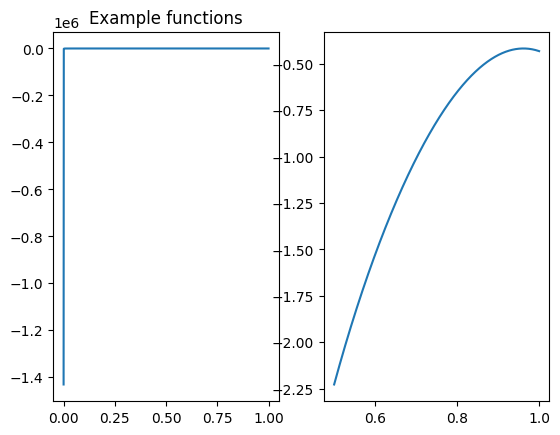

In [3]:
rng_gen = np.random.default_rng(seed)
F = example_problem(I, number_of_functions = 10, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()

print("Example function from function space")
display(ex_f_expr)
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2);
xx2 = np.linspace((I.a+I.b)/2,I.b,1000)
plt.plot(xx2,ex_f(xx2));

Discretization and compression

In [4]:
k = 30
x_disc, w_disc, endpoints, intervals = adaptive_discretization(F, eps_disc, k, verbose=False)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Functions before compression: 10
Functions after compression: 6


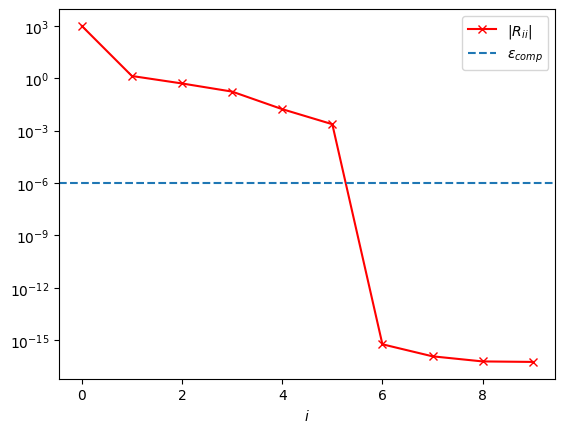

In [5]:
print("Functions before compression:", len(F.functions))
print("Functions after compression:", len(u_list))
visualise_diagonal_dropoff(A, eps_comp)

Chebyshev Rule

In [6]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)

In [7]:
print("Number of points in original discretization:", len(x_disc))
print("Number of points in Chebyshev rule:", len(x_cheb))
print("Absolute integral error for chebyshev:", abs(F.target_integral(ex_f_expr)-ex_f(x_cheb)@w_cheb))

Number of points in original discretization: 1140
Number of points in Chebyshev rule: 6
Absolute integral error for chebyshev: 1.13686837721616e-13


Naive nonlinear optimization

In [8]:
r = U_disc.T@w_disc
opt = QuadOptimizer(u_list,r)

In [9]:
args = (0.9, 1000, 1e-9)
x_naive, w_naive = opt.naive_optimization(rank//2, F.I, args)

In [10]:
print("Naive quadrature length: ", len(x_naive))
print("Naive error:", abs(F.target_integral(ex_f_expr)-ex_f(x_naive)@w_naive))

Naive quadrature length:  3
Naive error: 4.67562095707308e-8


In [11]:
r = U_disc.T@w_disc
x,w = opt.point_reduction(x_cheb, w_cheb, eps_quad)

In [13]:
print("Quadrature length: ", len(x))
print("Absolute error:", abs(F.target_integral(ex_f_expr)-ex_f(x)@w))

Quadrature length:  3
Absolute error: 5.48532619575326e-5
